# Kriging vs Gaussian Process regression: consistent prediction?

In this notebook, we investigate the **differences in Gaussian Process prediction results** between:
- Geostatistical packages such as **PyKrige** and **GSTools**, and
- Machine-learning packages such as **GPyTorch** and **SciKit-Learn**.

We perform this exercice both for a **1D prediction** (e.g., time series) and **2D prediction** (e.g., typical kriging in space).

We call functions living in:
- */spacetime/models.py* to define the models and predict on input data with **fixed covariance parameters**.
- */spacetime/conversions.py* to convert covariance functions between variograms (geostatistical packages) and kernels (machine-learning packages),

**There is no training, we are only interested in prediction! Covariance is defined arbitrarily.**

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

sys.path.insert(0, "..")
import spacetime.models
import spacetime.scaling

## Case of 1D data

### Step 1: Create example 1D data

We use the data from https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/05_kriging_1D.html (initially taken from
https://blog.dominodatalab.com/fitting-gaussian-process-models-python/)

In [2]:
# Construct 1D data
data = np.array([
     [-5.01, 1.06], [-4.90, 0.92], [-4.82, 0.35], [-4.69, 0.49], [-4.56, 0.52],
     [-4.52, 0.12], [-4.39, 0.47], [-4.32,-0.19], [-4.19, 0.08], [-4.11,-0.19],
     [-4.00,-0.03], [-3.89,-0.03], [-3.78,-0.05], [-3.67, 0.10], [-3.59, 0.44],
     [-3.50, 0.66], [-3.39,-0.12], [-3.28, 0.45], [-3.20, 0.14], [-3.07,-0.28],
     [-3.01,-0.46], [-2.90,-0.32], [-2.77,-1.58], [-2.69,-1.44], [-2.60,-1.51],
     [-2.49,-1.50], [-2.41,-2.04], [-2.28,-1.57], [-2.19,-1.25], [-2.10,-1.50],
     [-2.00,-1.42], [-1.91,-1.10], [-1.80,-0.58], [-1.67,-1.08], [-1.61,-0.79],
     [-1.50,-1.00], [-1.37,-0.04], [-1.30,-0.54], [-1.19,-0.15], [-1.06,-0.18],
     [-0.98,-0.25], [-0.87,-1.20], [-0.78,-0.49], [-0.68,-0.83], [-0.57,-0.15],
     [-0.50, 0.00], [-0.38,-1.10], [-0.29,-0.32], [-0.18,-0.60], [-0.09,-0.49],
     [0.03 ,-0.50], [0.09 ,-0.02], [0.20 ,-0.47], [0.31 ,-0.11], [0.41 ,-0.28],
     [0.53 , 0.40], [0.61 , 0.11], [0.70 , 0.32], [0.94 , 0.42], [1.02 , 0.57],
     [1.13 , 0.82], [1.24 , 1.18], [1.30 , 0.86], [1.43 , 1.11], [1.50 , 0.74],
     [1.63 , 0.75], [1.74 , 1.15], [1.80 , 0.76], [1.93 , 0.68], [2.03 , 0.03],
     [2.12 , 0.31], [2.23 ,-0.14], [2.31 ,-0.88], [2.40 ,-1.25], [2.50 ,-1.62],
     [2.63 ,-1.37], [2.72 ,-0.99], [2.80 ,-1.92], [2.83 ,-1.94], [2.91 ,-1.32],
     [3.00 ,-1.69], [3.13 ,-1.84], [3.21 ,-2.05], [3.30 ,-1.69], [3.41 ,-0.53],
     [3.52 ,-0.55], [3.63 ,-0.92], [3.72 ,-0.76], [3.80 ,-0.41], [3.91 , 0.12],
     [4.04 , 0.25], [4.13 , 0.16], [4.24 , 0.26], [4.32 , 0.62], [4.44 , 1.69],
     [4.52 , 1.11], [4.65 , 0.36], [4.74 , 0.79], [4.84 , 0.87], [4.93 , 1.01],
     [5.02 , 0.55]
])

# Randomly subsample 10 points
np.random.seed(42)
ind_subsample_data = np.random.choice(len(data), 10, replace=False)
data = data[ind_subsample_data, :]

### Step 2: Define covariance and output grid

The conversion of concepts between variogram models and kernels is the following:
- **Correlation range** (variogram) = **Lengthscale** (kernel), often scaled with different factors (in geostats, those factor serve to have effective range values that represent the distance at which two points largely decorrelate),
- **Partial sill** (variogram) = **Outputscale** (kernel), often defined the same,
- **Nugget** (variogram) = **Noise level** (kernel), defined the same in the case of homoscedastic processes (fixed measurement error).

In [3]:
# We define the covariance with a variogram model, later converted into kernel for machine-learning packages
variogram_model = {"model_name": "gaussian", "range": 2, "psill": 2, "nugget": 0.0001}  # Nugget at the lowest value (=almost no error)
# We predict the output on -6 to 6
gridx = np.linspace(-6, 6, 200)

### Step 3: Run prediction for fixed covariance with all packages

We compute both predicted **means** and **stds**, and plot them all together.

We use slightly different linewidths with dotted linestyle to see super-imposed **std** curves.

In [4]:
# Outputs are: mean, sigma, model
y_gpy, sig_gpy, m_gpy = spacetime.models.gpytorch_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data)
y_skl, sig_skl, m_skl = spacetime.models.sklearn_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data)
y_pyk, sig_pyk, m_pyk = spacetime.models.pykrige_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data)
y_gst, sig_gst, m_gst = spacetime.models.gstools_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data)

(-5.0, 5.0)

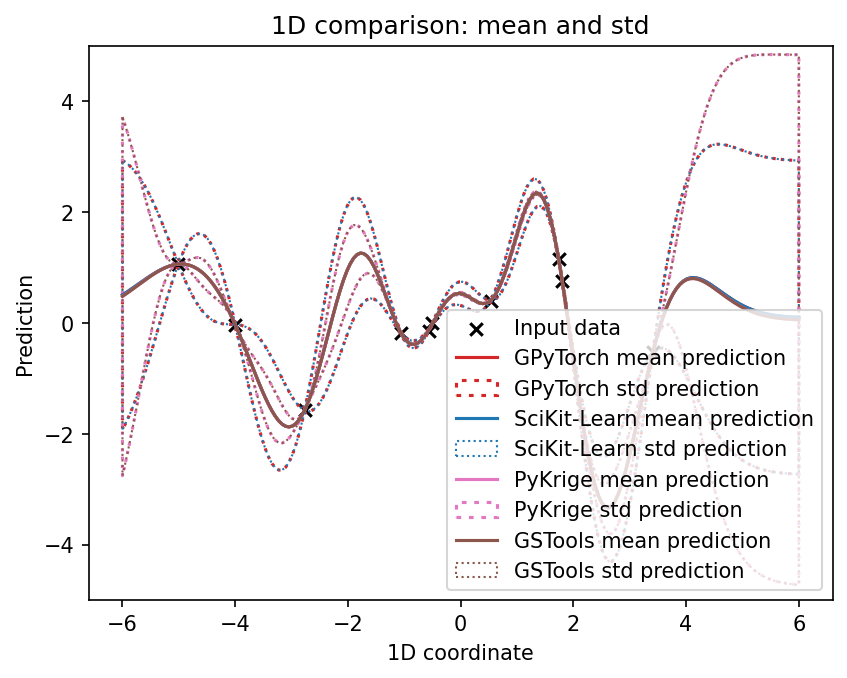

In [5]:
plt.figure()
plt.scatter(data[:, 0], data[:, 1], c='black', marker="x", label="Input data")
plt.plot(gridx, y_gpy, c="tab:red", linewidth=1.5, label="GPyTorch mean prediction")
plt.fill_between(gridx, y_gpy - 2*sig_gpy, y_gpy + 2*sig_gpy, edgecolor="tab:red", facecolor="None",linestyle="dotted", linewidth=1.5, label="GPyTorch std prediction")
# plt.plot(gridx, c="tab:red", linestyle="dashed", label="GPyTorch std prediction")
plt.plot(gridx, y_skl, c="tab:blue", label="SciKit-Learn mean prediction")
plt.fill_between(gridx, y_skl+ 2*sig_skl, y_skl-2*sig_skl, edgecolor="tab:blue", facecolor="None",linestyle="dotted", label="SciKit-Learn std prediction")
plt.plot(gridx, y_pyk, c="tab:pink", linewidth=1.5, label="PyKrige mean prediction")
plt.fill_between(gridx, y_pyk - 2*sig_pyk, y_pyk+2*sig_pyk, edgecolor="tab:pink", facecolor="None",linestyle="dotted", linewidth=1.5, label="PyKrige std prediction")
plt.plot(gridx, y_gst, c="tab:brown", label="GSTools mean prediction")
plt.fill_between(gridx, y_gst-2*sig_gst, y_gst+2*sig_gst, edgecolor="tab:brown", facecolor="None", linestyle="dotted", label="GSTools std prediction")
plt.xlabel("1D coordinate")
plt.ylabel("Prediction")
plt.title("1D comparison: mean and std")
plt.legend()
plt.ylim((-5, 5))

We see that all **means** are super-imposed, so very close except near the edge of the graph (right side mostly).

But there are two clearly distinct sets of **stds** predicted... Something is going on.

### Step 4: Compare the residuals between outputs

Hard to see the difference on the plot of predicted values with so many things super-imposed.

So we plot the **absolute differences to the GPyTorch predicted means and stds**.

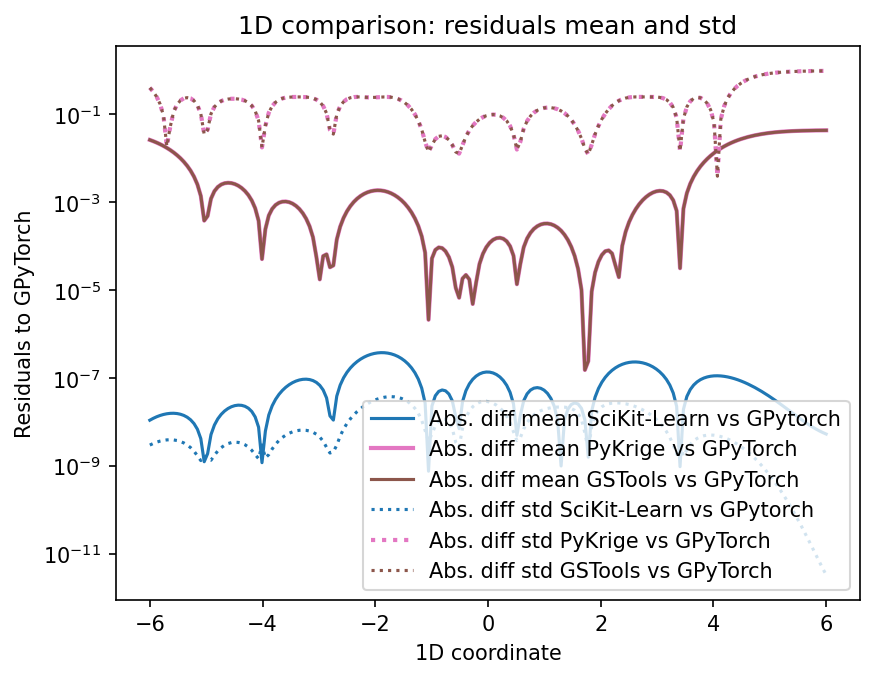

In [6]:
plt.figure()
# Means
plt.plot(gridx, np.abs(y_skl - y_gpy), c="tab:blue", label="Abs. diff mean SciKit-Learn vs GPytorch")
plt.plot(gridx, np.abs(y_pyk - y_gpy), c="tab:pink", linewidth=2, label="Abs. diff mean PyKrige vs GPyTorch")
plt.plot(gridx, np.abs(y_gst - y_gpy), c="tab:brown", label="Abs. diff mean GSTools vs GPyTorch")
# Standard deviations
plt.plot(gridx, np.abs(sig_skl - sig_gpy), c="tab:blue", linestyle="dotted", label="Abs. diff std SciKit-Learn vs GPytorch")
plt.plot(gridx, np.abs(sig_pyk - sig_gpy), c="tab:pink", linestyle="dotted", linewidth=2, label="Abs. diff std PyKrige vs GPyTorch")
plt.plot(gridx, np.abs(sig_gst - sig_gpy), c="tab:brown", linestyle="dotted", label="Abs. diff std GSTools vs GPyTorch")
plt.xlabel("1D coordinate")
plt.ylabel("Residuals to GPyTorch")
plt.title("1D comparison: residuals mean and std")
plt.legend()
ax = plt.gca()
ax.set_yscale("log")
plt.show()

We see that:
- **All mean predictions are fairly close (10e-4 on average, 10e-2 at the edges)**, but **there is nonetheless a discrepancy between ML and geostats packages**: ML packages are extremely close between themselves **(10e-8)**, and geostatistical packages also (super-imposed residual curves), but both kind differ.
- **Std predictions are even further off between ML and geostats packages**, which shows directly in the predicted plots.

# Case of 2D data

### Step 1: Create placeholder data

We use the 2D data from https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/00_ordinary.html.

In [7]:
data2 = np.array(
    [
        [0.3, 1.2, 0.47],
        [1.9, 0.6, 0.56],
        [1.1, 3.2, 0.74],
        [3.3, 4.4, 1.47],
        [4.7, 3.8, 1.74],
    ]
)

### Step 2: Define covariance and output grid

We reuse the same covariance as above, shared between the 2 dimensions of space. And define a grid from 0 to 5 where to predict. 

In [8]:
gridx = np.arange(0.0, 5.5, 0.5)
gridy = np.arange(0.0, 5.5, 0.5)

### Step 3 + 4: Run prediction for fixed covariance with all packages and compare residuals

We compute both predicted **means** and **stds**, and plot them all together.

In [9]:
yy_gpy, ss_gpy, mm_gpy = spacetime.models.gpytorch_predict_2d(variogram_model=variogram_model, gridx=gridx, gridy=gridy, data=data2)
yy_pyk, ss_pyk, mm_pyk = spacetime.models.pykrige_predict_2d(variogram_model=variogram_model, gridx=gridx, gridy=gridy, data=data2)
yy_skl, ss_skl, mm_skl = spacetime.models.sklearn_predict_2d(variogram_model=variogram_model, gridx=gridx, gridy=gridy, data=data2)
yy_gst, ss_gst, mm_gst = spacetime.models.gstools_predict_2d(variogram_model=variogram_model, gridx=gridx, gridy=gridy, data=data2)

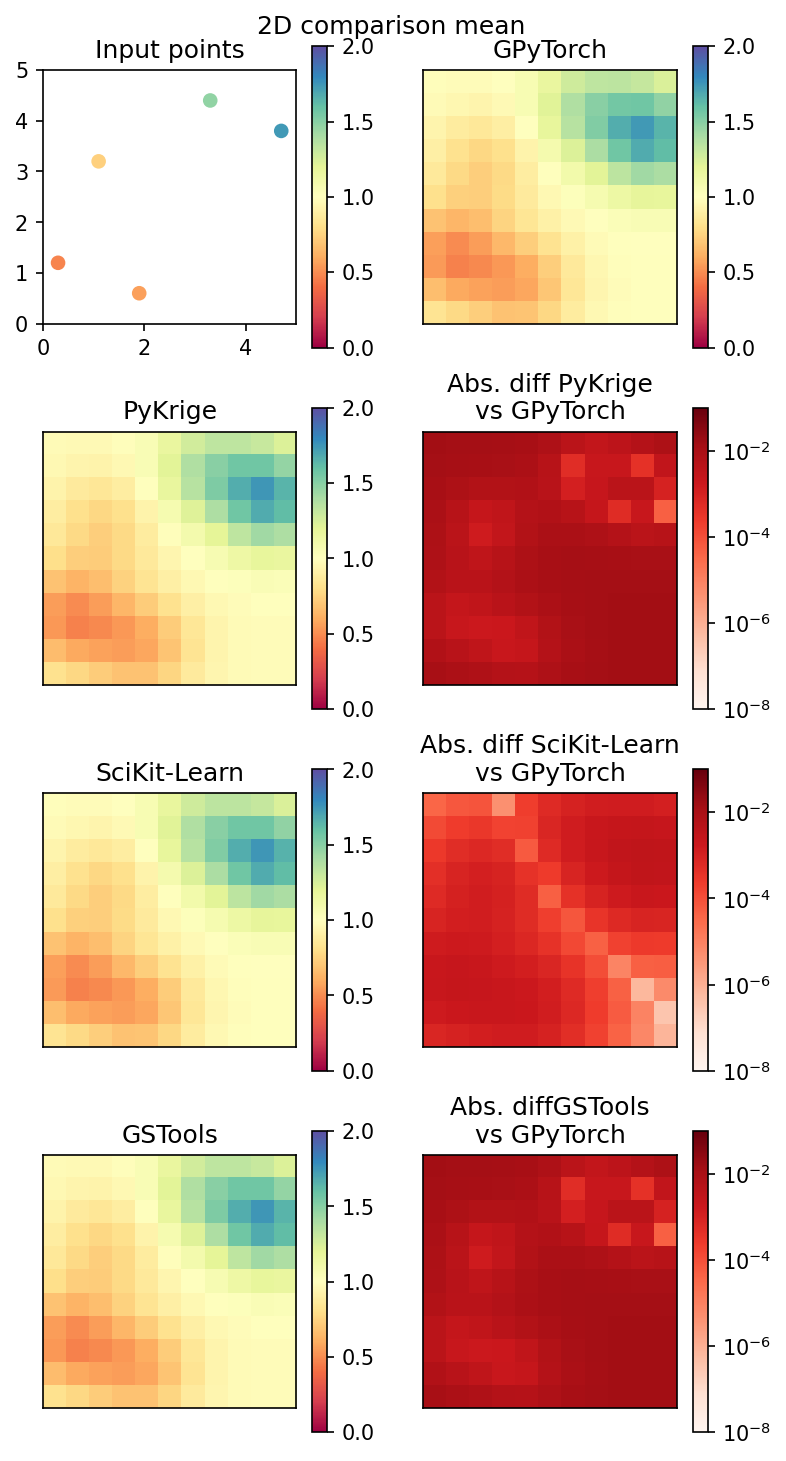

In [10]:
# Define keyword arguments for prediction + residual colormaps
kwargs_cmap_mean = {"vmin": 0, "vmax": 2, "cmap": "Spectral"}
kwargs_cmap_res = {"cmap": "Reds", "norm": mpl.colors.LogNorm(vmin=10**(-8), vmax=0.1)}

# First figure: we compare mean values
plt.figure(figsize=(6, 12))
plt.title("2D comparison mean")
plt.axis('off')
plt.subplot(4, 2, 1)
plt.scatter(x=data2[:, 0], y=data2[:, 1], c=data2[:, 2], **kwargs_cmap_mean)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.colorbar()
plt.title("Input points")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# Function for consistent 2D plot
def subplot_imshow(pos, pred, title, kwargs_cmap):

    plt.subplot(*pos)
    plt.imshow(pred, **kwargs_cmap, origin="lower")
    plt.colorbar()
    plt.title(title)
    ax = plt.gca()
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
subplot_imshow(pos=(4, 2, 2), pred=yy_gpy.reshape((len(gridx), len(gridy))), title="GPyTorch", kwargs_cmap=kwargs_cmap_mean)
subplot_imshow(pos=(4, 2, 3), pred=yy_pyk.reshape((len(gridx), len(gridy))), title="PyKrige", kwargs_cmap=kwargs_cmap_mean)
abs_diff_pyk = np.abs(yy_pyk.reshape((len(gridx), len(gridy))) - yy_gpy.reshape((len(gridx), len(gridy))))
subplot_imshow(pos=(4, 2, 4), pred=abs_diff_pyk, title="Abs. diff PyKrige\nvs GPyTorch", kwargs_cmap=kwargs_cmap_res)
subplot_imshow(pos=(4, 2, 5), pred=yy_skl.reshape((len(gridx), len(gridy))), title="SciKit-Learn", kwargs_cmap=kwargs_cmap_mean)
abs_diff_skl = np.abs(yy_skl.reshape((len(gridx), len(gridy))) - yy_gpy.reshape((len(gridx), len(gridy))))
subplot_imshow(pos=(4, 2, 6), pred=abs_diff_skl, title="Abs. diff SciKit-Learn\nvs GPyTorch", kwargs_cmap=kwargs_cmap_res)
subplot_imshow(pos=(4, 2, 7), pred=yy_gst.reshape((len(gridx), len(gridy))), title="GSTools", kwargs_cmap=kwargs_cmap_mean)
abs_diff_gst = np.abs(yy_gst.reshape((len(gridx), len(gridy))) - yy_gpy.reshape((len(gridx), len(gridy))))
subplot_imshow(pos=(4, 2, 8), pred=abs_diff_gst, title="Abs. diffGSTools\nvs GPyTorch", kwargs_cmap=kwargs_cmap_res)

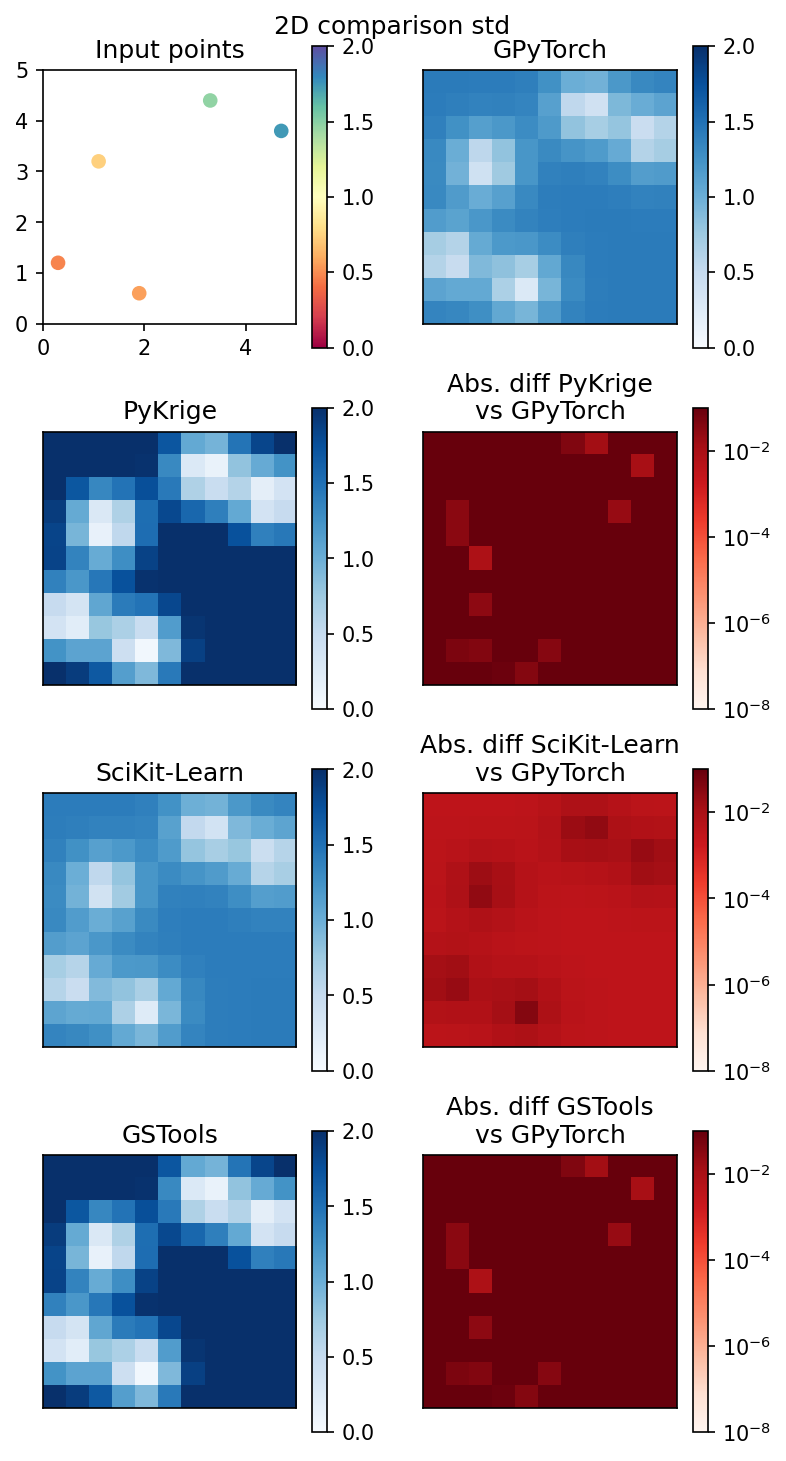

In [11]:
# Second figure: we compare std values
plt.figure(figsize=(6, 12))
plt.title("2D comparison std")
plt.axis('off')
plt.subplot(4, 2, 1)
plt.scatter(x=data2[:, 0], y=data2[:, 1], c=data2[:, 2], **kwargs_cmap_mean)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.colorbar()
plt.title("Input points")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
kwargs_cmap_mean = {"vmin": 0, "vmax": 2, "cmap": "Blues"}
subplot_imshow(pos=(4, 2, 2), pred=ss_gpy.reshape((len(gridx), len(gridy))), title="GPyTorch", kwargs_cmap=kwargs_cmap_mean)
subplot_imshow(pos=(4, 2, 3), pred=ss_pyk.reshape((len(gridx), len(gridy))), title="PyKrige", kwargs_cmap=kwargs_cmap_mean)
abs_diff_pyk = np.abs(ss_pyk.reshape((len(gridx), len(gridy))) - ss_gpy.reshape((len(gridx), len(gridy))))
subplot_imshow(pos=(4, 2, 4), pred=abs_diff_pyk, title="Abs. diff PyKrige\nvs GPyTorch", kwargs_cmap=kwargs_cmap_res)
subplot_imshow(pos=(4, 2, 5), pred=ss_skl.reshape((len(gridx), len(gridy))), title="SciKit-Learn", kwargs_cmap=kwargs_cmap_mean)
abs_diff_skl = np.abs(ss_skl.reshape((len(gridx), len(gridy))) - ss_gpy.reshape((len(gridx), len(gridy))))
subplot_imshow(pos=(4, 2, 6), pred=abs_diff_skl, title="Abs. diff SciKit-Learn\nvs GPyTorch", kwargs_cmap=kwargs_cmap_res)
subplot_imshow(pos=(4, 2, 7), pred=ss_gst.reshape((len(gridx), len(gridy))), title="GSTools", kwargs_cmap=kwargs_cmap_mean)
abs_diff_gst = np.abs(ss_gst.reshape((len(gridx), len(gridy))) - ss_gpy.reshape((len(gridx), len(gridy))))
subplot_imshow(pos=(4, 2, 8), pred=abs_diff_gst, title="Abs. diff GSTools\nvs GPyTorch", kwargs_cmap=kwargs_cmap_res)

We reach the same conclusions in 2D than in 1D:
- The **predicted means are reasonably close for all methods**, but **still show much larger difference between geostatistical and machine-learning packages** (10e-2) than within the same kind (10e-8).
- The **predicted stds are fairly different (in the order of magnitude of input data)**, while yet again consistent for the same kind of packages.

## Final step: Investigate the origin of differences

**So where do these differences come from?!**

**To check if wrong conversion of covariance parameters between ML kernels and geostat variograms are the cause (see */spacetime/conversions.py*)**, we slightly vary the parameters of the variogram and update the PyKrige predictions (as an example of geostat package) to see the difference to GPyTorch (as an example of ML).

We go back to the 1D data.

(-5.0, 5.0)

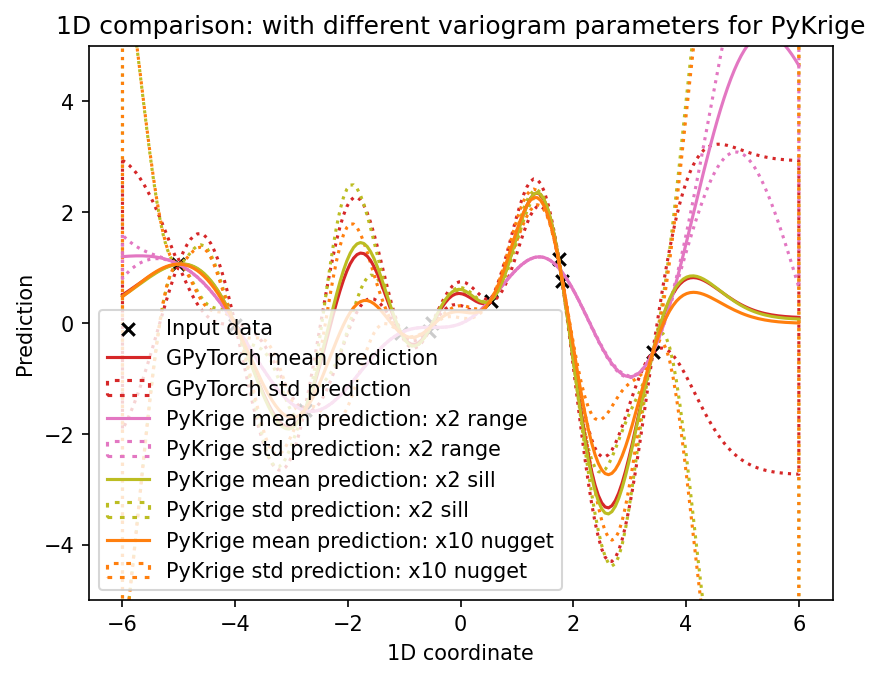

In [12]:
# We vary the variogram parameters slightly and independently for PyKrige, and compare to GPyTorch
gridx = np.linspace(-6, 6, 200)
# Range times 2
variogram_model_2 = {"model_name": "gaussian", "range": 4, "psill": 2, "nugget": 0.0001}
y_pyk2, sig_pyk2, m_pyk2 = spacetime.models.pykrige_predict_1d(variogram_model=variogram_model_2, gridx=gridx, data=data)

# Partial sill times 2
variogram_model_3 = {"model_name": "gaussian", "range": 2, "psill": 4, "nugget": 0.0001}
y_pyk3, sig_pyk3, m_pyk3 = spacetime.models.pykrige_predict_1d(variogram_model=variogram_model_3, gridx=gridx, data=data)

# Nugget times 10
variogram_model_4 = {"model_name": "gaussian", "range": 2, "psill": 4, "nugget": 0.0010}
y_pyk4, sig_pyk4, m_pyk4 = spacetime.models.pykrige_predict_1d(variogram_model=variogram_model_4, gridx=gridx, data=data)

# Plot the predictions directly
plt.figure()
plt.scatter(data[:, 0], data[:, 1], c='black', marker="x", label="Input data")
plt.plot(gridx, y_gpy, c="tab:red", linewidth=1.5, label="GPyTorch mean prediction")
plt.fill_between(gridx, y_gpy - 2*sig_gpy, y_gpy + 2*sig_gpy, edgecolor="tab:red", facecolor="None",linestyle="dotted", linewidth=1.5, label="GPyTorch std prediction")
plt.plot(gridx, y_pyk2, c="tab:pink", linewidth=1.5, label="PyKrige mean prediction: x2 range")
plt.fill_between(gridx, y_pyk2 - 2*sig_pyk2, y_pyk2+2*sig_pyk2, edgecolor="tab:pink", facecolor="None",linestyle="dotted", linewidth=1.5, label="PyKrige std prediction: x2 range")
plt.plot(gridx, y_pyk3, c="tab:olive", linewidth=1.5, label="PyKrige mean prediction: x2 sill")
plt.fill_between(gridx, y_pyk3 - 2*sig_pyk3, y_pyk3+2*sig_pyk3, edgecolor="tab:olive", facecolor="None",linestyle="dotted", linewidth=1.5, label="PyKrige std prediction: x2 sill")
plt.plot(gridx, y_pyk4, c="tab:orange", linewidth=1.5, label="PyKrige mean prediction: x10 nugget")
plt.fill_between(gridx, y_pyk4 - 2*sig_pyk4, y_pyk4+2*sig_pyk4, edgecolor="tab:orange", facecolor="None",linestyle="dotted", linewidth=1.5, label="PyKrige std prediction: x10 nugget")
plt.xlabel("1D coordinate")
plt.ylabel("Prediction")
plt.title("1D comparison: with different variogram parameters for PyKrige")
plt.legend()
plt.ylim((-5, 5))

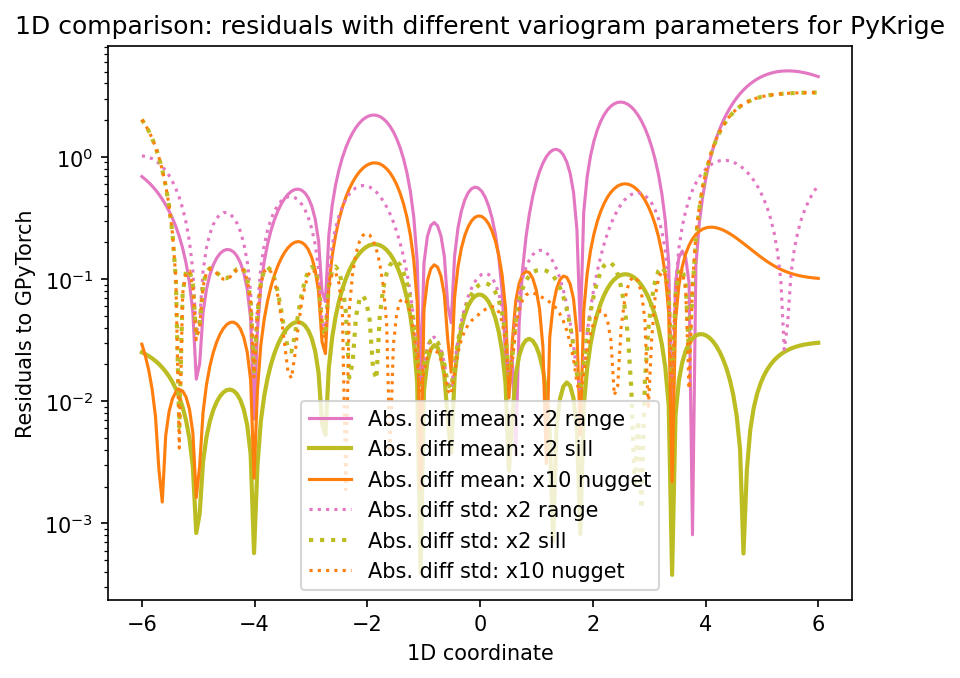

In [13]:
# Now plot the residuals
plt.figure()
# Means
plt.plot(gridx, np.abs(y_pyk2 - y_gpy), c="tab:pink", label="Abs. diff mean: x2 range")
plt.plot(gridx, np.abs(y_pyk3 - y_gpy), c="tab:olive", linewidth=2, label="Abs. diff mean: x2 sill")
plt.plot(gridx, np.abs(y_pyk4 - y_gpy), c="tab:orange", label="Abs. diff mean: x10 nugget")
# Standard deviations
plt.plot(gridx, np.abs(sig_pyk2 - sig_gpy), c="tab:pink", linestyle="dotted", label="Abs. diff std: x2 range")
plt.plot(gridx, np.abs(sig_pyk3 - sig_gpy), c="tab:olive", linestyle="dotted", linewidth=2, label="Abs. diff std: x2 sill")
plt.plot(gridx, np.abs(sig_pyk4 - sig_gpy), c="tab:orange", linestyle="dotted", label="Abs. diff std: x10 nugget")
plt.xlabel("1D coordinate")
plt.ylabel("Residuals to GPyTorch")
plt.title("1D comparison: residuals with different variogram parameters for PyKrige")
plt.legend()
ax = plt.gca()
ax.set_yscale("log")
plt.show()

This time, we can see the misfits directly on the plot of predictions (curves are not super-imposed). The residuals of both predicted **means** and **stds** are quite large, around **10e-1** on average.

A small difference in covariance parameters results in a massive different in prediction. This hints that **our conversions between ML kernels and geostat variogram seems to be correct and not the source of our problem.**

However, the nugget parameter is the least sensitive. Additionally, it's been set very low (0.0001 = minimal value accepted in most packages). Let's try predictions with larger nuggets!

In [14]:
# Derive prediction for ML package and geostat package with larger nugget
variogram_model_5 = {"model_name": "gaussian", "range": 2, "psill": 2, "nugget": 1}
y_gpy5, sig_gpy5, m_gpy = spacetime.models.gpytorch_predict_1d(variogram_model=variogram_model_5, gridx=gridx, data=data)
y_pyk5, sig_pyk5, m_pyk = spacetime.models.pykrige_predict_1d(variogram_model=variogram_model_5, gridx=gridx, data=data)

(-5.0, 5.0)

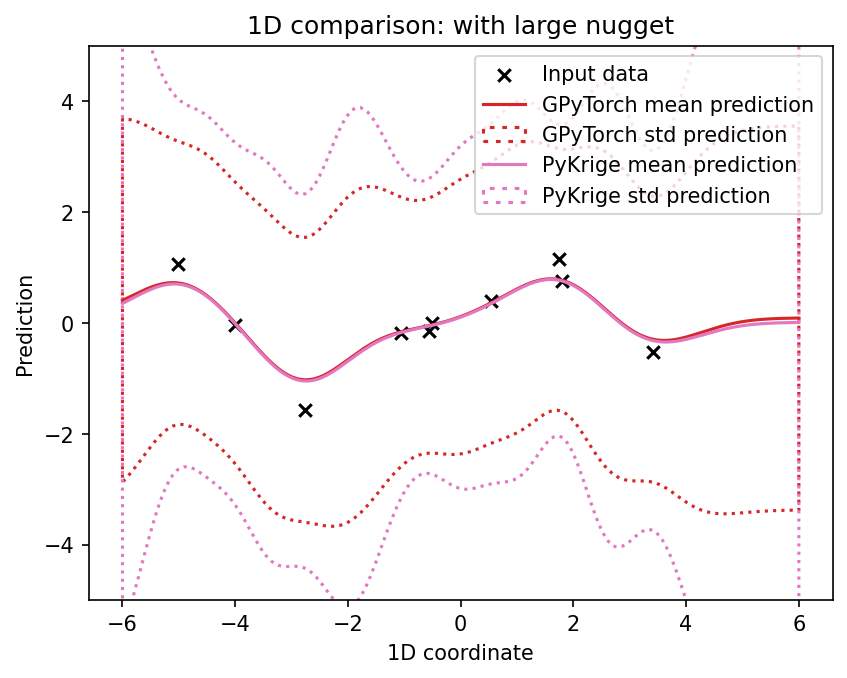

In [15]:
# Plot the predictions
plt.figure()
plt.scatter(data[:, 0], data[:, 1], c='black', marker="x", label="Input data")
plt.plot(gridx, y_gpy5, c="tab:red", linewidth=1.5, label="GPyTorch mean prediction")
plt.fill_between(gridx, y_gpy5 - 2*sig_gpy5, y_gpy5 + 2*sig_gpy5, edgecolor="tab:red", facecolor="None",linestyle="dotted", linewidth=1.5, label="GPyTorch std prediction")
plt.plot(gridx, y_pyk5, c="tab:pink", linewidth=1.5, label="PyKrige mean prediction")
plt.fill_between(gridx, y_pyk5 - 2*sig_pyk5, y_pyk5+2*sig_pyk5, edgecolor="tab:pink", facecolor="None",linestyle="dotted", linewidth=1.5, label="PyKrige std prediction")
plt.xlabel("1D coordinate")
plt.ylabel("Prediction")
plt.title("1D comparison: with large nugget")
plt.legend()
plt.ylim((-5, 5))

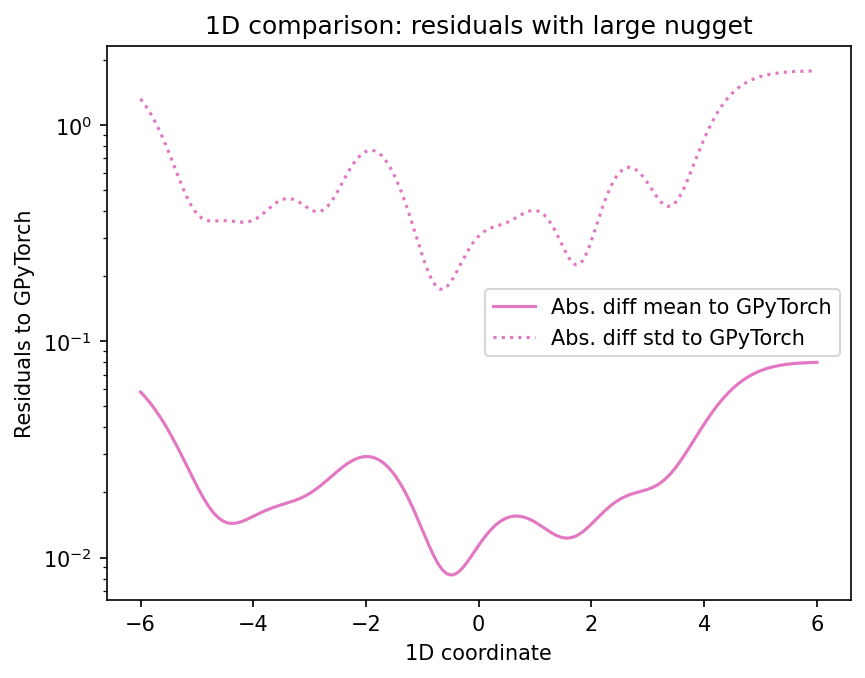

In [16]:
# Now plot the residuals
plt.figure()
# Means
plt.plot(gridx, np.abs(y_pyk5 - y_gpy5), c="tab:pink", label="Abs. diff mean to GPyTorch")
# Standard deviations
plt.plot(gridx, np.abs(sig_pyk5 - sig_gpy5), c="tab:pink", linestyle="dotted", label="Abs. diff std to GPyTorch")
plt.xlabel("1D coordinate")
plt.ylabel("Residuals to GPyTorch")
plt.title("1D comparison: residuals with large nugget")
plt.legend()
ax = plt.gca()
ax.set_yscale("log")
plt.show()

The magnitude of difference of **means** is relatively small, but still increases with larger nuggets (from 10e-4 to 10e-2), so might be related. The current **nugget** is 1, which is the same in variance or in measurement error (squareroot), so conversion between packages should not be an issue.

More investigation is needed to reconcile both kind of packages! 

**Way forward: Likely opening an issue in PyKrige + GPyTorch to get advice from the core developers.**